# Sprint 13 | Time Series

## Introduction

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

**Project instructions**

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

**Data description**

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Initialization

In [3]:
# Data analysis
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Data visualization
import matplotlib.pyplot as plt

# Model and performance
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_validate, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

## Load Data

In [4]:
# Load data and set index as datetime
df = pd.read_csv('/Users/laceymalarky/git_projects/python-exercises/TripleTen/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [7]:
# Check that dates are sorted chronologically
print(df.index.is_monotonic_increasing)

True


In [8]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [10]:
# Check for missing values
df.isna().sum()

num_orders    0
dtype: int64

In [11]:
# Resample total orders each hour
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## EDA

### Moving Average

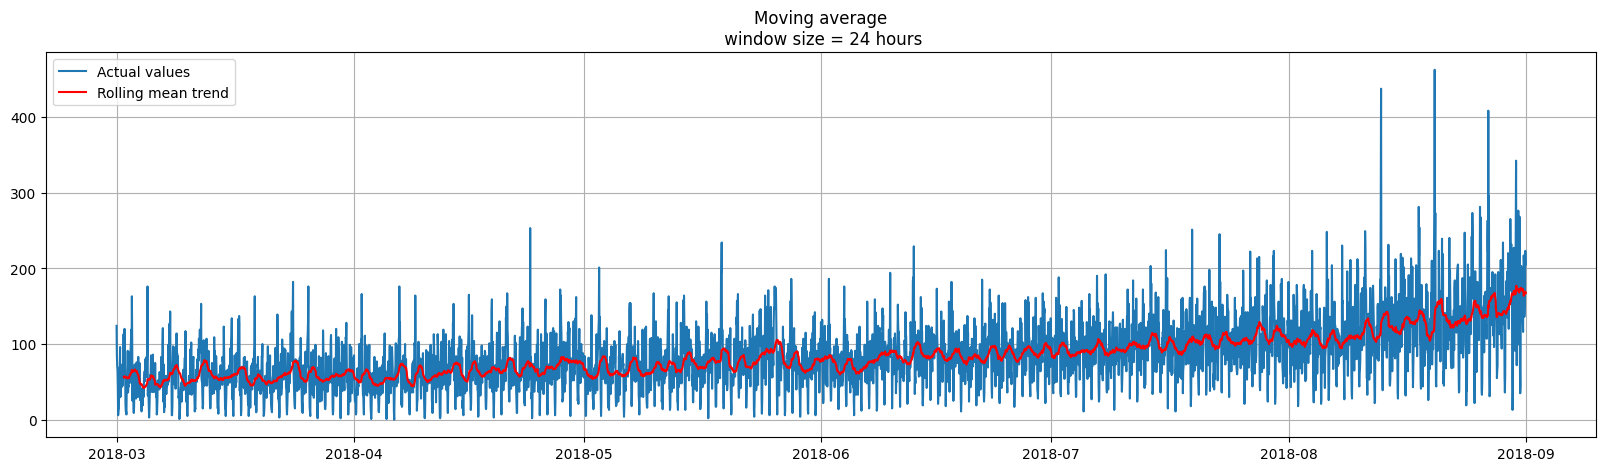

In [12]:
# Plot data with moving average
window = 24
rolling_mean = df.rolling(window=window).mean()

plt.figure(figsize=(20,5))
plt.title(f'Moving average\n window size = {window} hours')
plt.plot(df,  label='Actual values')
plt.plot(rolling_mean, 'r', label="Rolling mean trend")
plt.legend(loc="upper left")
plt.grid(True)

### Trend & Seasonality

In [13]:
decomposed = seasonal_decompose(df)

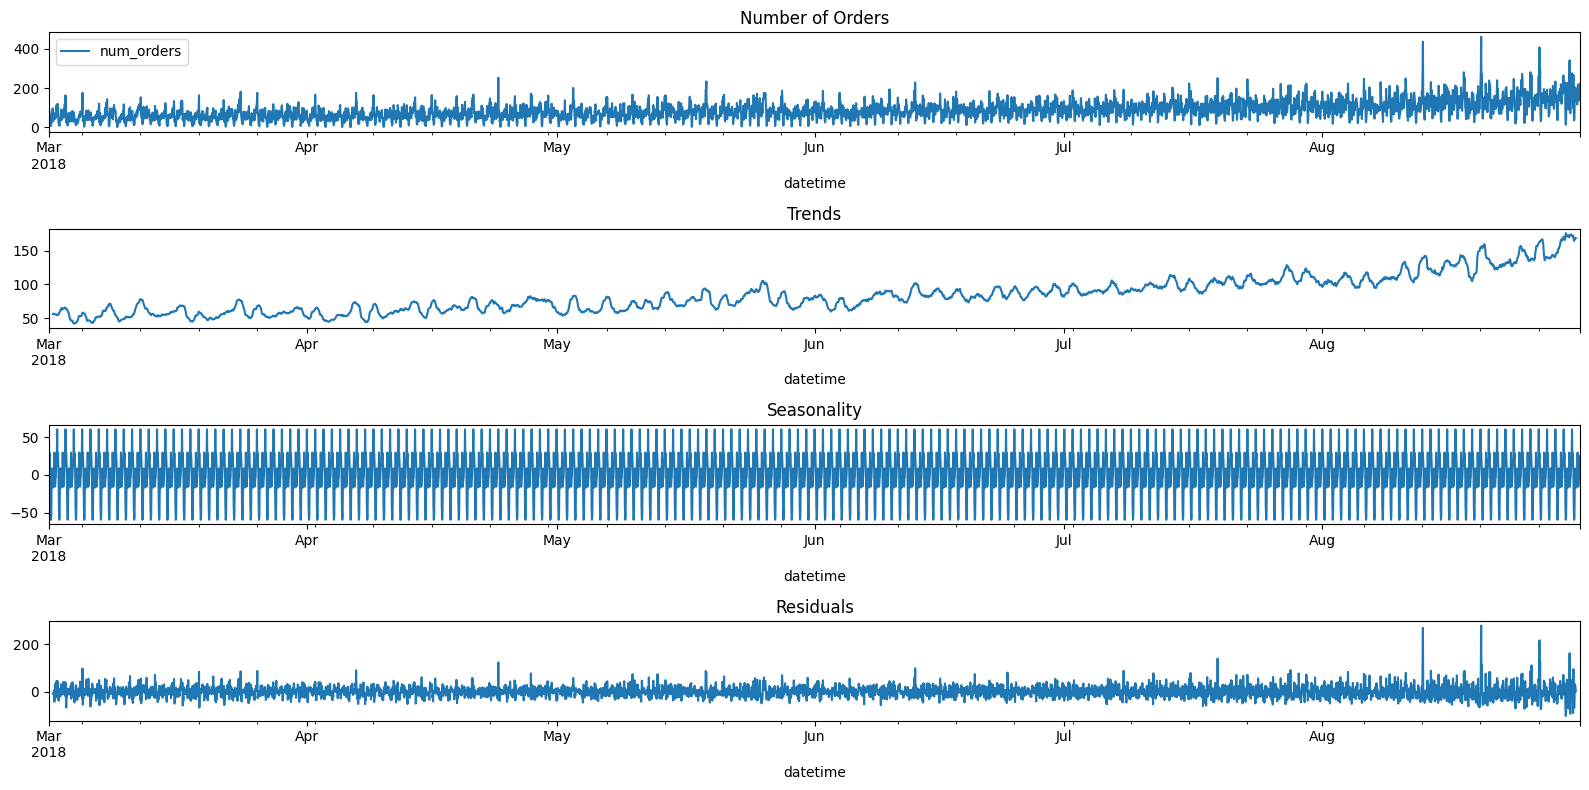

In [14]:
plt.figure(figsize=(16,8))

plt.subplot(411)
df.plot(ax=plt.gca())
plt.title('Number of Orders')

plt.subplot(412)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trends')

plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

<Axes: xlabel='datetime'>

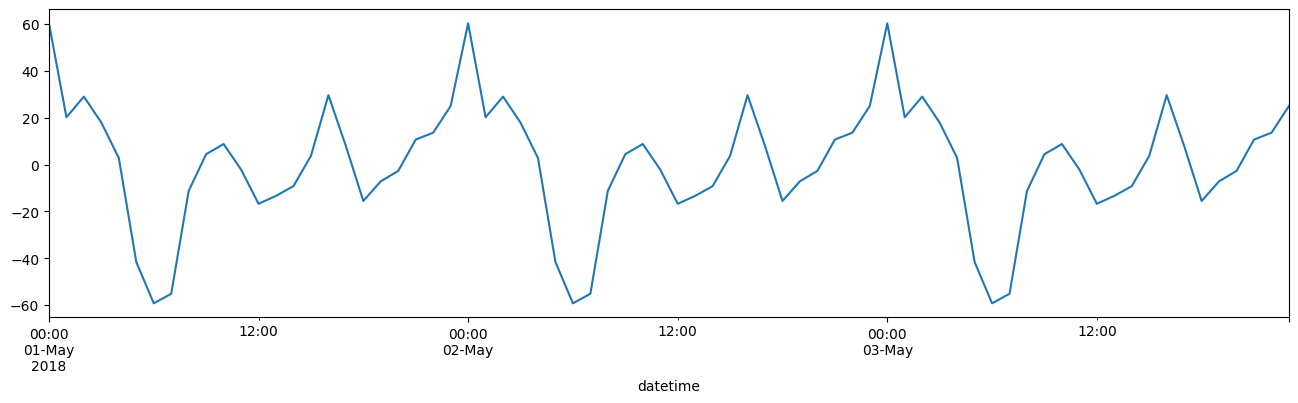

In [15]:
# Seasonailty subset
decomposed.seasonal['2018-05-01':'2018-05-03'].plot(figsize=(16,4))

**Conclusions**
- Trend values range from about 40 to 175/hour and increasing over time
- There is strong seasonality within a 24 hour period
    - Daily swings of about +/- 120
    - Peaks around Midnight
    - Lows around 6AM
- Residuals show there was highest variability in August

### Autocorrelation

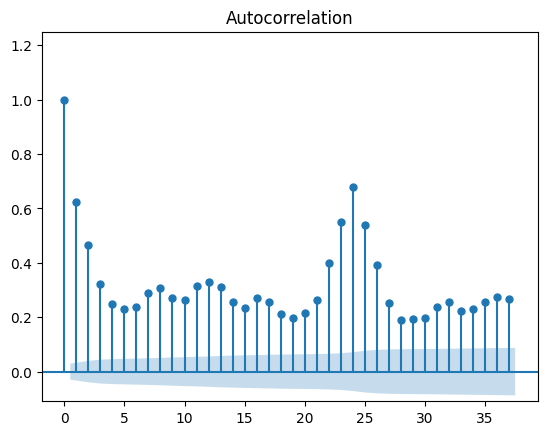

In [16]:
# Plot the autocorrelation function
plot_acf(df.values, auto_ylims=True)
plt.show()

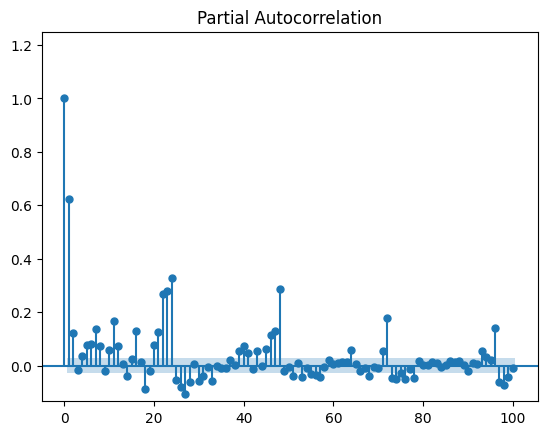

In [17]:
# Plot the partial autocorrelation estimate
plot_pacf(df.values, lags=100, auto_ylims=True)
plt.show()

**Conclusions:**
- Based on ACF, there is a positive correlation within 24 hours
- Based on PACF, there is the strongest correlation between the current hour and the next hour and then 24 hours later (hours 22, 23, 24, 48, 72)
- In feature engineering, we should:
    - set the rolling window to 24 hours
    - create lag features for 24 hours

## Feature Engineering

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    # Calendar features
    #data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # Lag features
    for i in range(1, max_lag + 1):
        data['lag_'+str(i)] = data['num_orders'].shift(i)
    
    # Rolling mean
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    # Cumulative sum
    data['expanding'] = data['num_orders'].shift().expanding().sum()
    
    return data

In [19]:
df = make_features(df, 24, 24)
df.shape

(4416, 31)

In [20]:
df.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean,expanding
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.0
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209.0
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280.0
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,346.0


In [21]:
# Remove any rows with NaNs
df = df.dropna()
df.shape

(4392, 31)

In [22]:
df.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean,expanding
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,0,58.0,113.0,66.0,61.0,45.0,...,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333,1364.0
2018-03-02 01:00:00,120,3,2,4,1,90.0,58.0,113.0,66.0,61.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667,1454.0
2018-03-02 02:00:00,75,3,2,4,2,120.0,90.0,58.0,113.0,66.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000,1574.0
2018-03-02 03:00:00,64,3,2,4,3,75.0,120.0,90.0,58.0,113.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667,1649.0
2018-03-02 04:00:00,20,3,2,4,4,64.0,75.0,120.0,90.0,58.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333,1713.0


## Training

In [23]:
def rmse(prediction, target):
    return mean_squared_error(prediction, target, squared=False)

**Split data**

In [24]:
# Set features/target
X = df.drop(columns=['num_orders'])
y = df['num_orders']

In [25]:
# Split data
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, shuffle=False, test_size=0.1)

In [26]:
print(X_train.shape, X_train.index.min(), X_train.index.max())
print(X_valid.shape, X_valid.index.min(), X_valid.index.max())
print(X_test.shape, X_test.index.min(), X_test.index.max())

(3556, 30) 2018-03-02 00:00:00 2018-07-28 03:00:00
(396, 30) 2018-07-28 04:00:00 2018-08-13 15:00:00
(440, 30) 2018-08-13 16:00:00 2018-08-31 23:00:00


### Linear Regression

In [27]:
# Scale features
scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [28]:
%%time
model_lr = LinearRegression()

# Train model
model_lr.fit(X_train_scaled, y_train)
# Predictions
pred_train = model_lr.predict(X_train_scaled)
pred_valid = model_lr.predict(X_valid_scaled)

#Evaluate model
rmse_train = rmse(pred_train, y_train)
rmse_valid = rmse(pred_valid, y_valid)

print('Linear Regression:')
print(f'RMSE (train): {rmse_train:0.2f}')
print(f'RMSE (valid): {rmse_valid:0.2f}')

Linear Regression:
RMSE (train): 24.58
RMSE (valid): 34.04
CPU times: user 408 ms, sys: 405 ms, total: 814 ms
Wall time: 126 ms


**Conclusion:**
- This model performs well.

### Decision Tree

In [29]:
%%time
model_dt = DecisionTreeRegressor(random_state=0)

# Set possible parameters
params = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'max_leaf_nodes': [3, 6, 9, None],
    'min_samples_split': [2, 3, 4],
 }

# Use time series cross validation
tscv = TimeSeriesSplit()

gs = GridSearchCV(model_dt, param_grid=params, cv=tscv, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)

# Best hyperparameters
print(f'Best hyperparameters:, {gs.best_params_}')

# Ssave best model
model_dt = gs.best_estimator_

Best hyperparameters:, {'max_depth': 4, 'max_leaf_nodes': None, 'min_samples_split': 2}
CPU times: user 4.25 s, sys: 20.6 ms, total: 4.27 s
Wall time: 4.27 s


In [30]:
# Predictions
pred_train = model_dt.predict(X_train)
pred_valid = model_dt.predict(X_valid)

# Evaluation
rmse_train = rmse(pred_train, y_train)
rmse_valid = rmse(pred_valid, y_valid)

print('Decision Tree:')
print(f'RMSE (train): {rmse_train:0.2f}')
print(f'RMSE (valid): {rmse_valid:0.2f}')

Decision Tree:
RMSE (train): 24.68
RMSE (valid): 41.30


**Conclusions:**
- The decision tree model does not perform as well as linear regression.

### Random Forest

In [31]:
%%time
model_rf = RandomForestRegressor(random_state=0)

# Set possible parameters
params = {
    'n_estimators' : [100, 150, 200],
    'max_depth': [3, 5, 7, 9, None]
 }

# Use time series cross validation
tscv = TimeSeriesSplit()

gs = GridSearchCV(model_rf, param_grid=params, cv=tscv, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)

# Best hyperparameters
print(f'Best hyperparameters:, {gs.best_params_}')

# Save best model
model_rf = gs.best_estimator_

Best hyperparameters:, {'max_depth': None, 'n_estimators': 200}
CPU times: user 2min 3s, sys: 339 ms, total: 2min 4s
Wall time: 2min 4s


In [32]:
# Predictions
pred_train = model_rf.predict(X_train)
pred_valid = model_rf.predict(X_valid)

# Evaluation
rmse_train = rmse(pred_train, y_train)
rmse_valid = rmse(pred_valid, y_valid)

print('Random Forest:')
print(f'RMSE (train): {rmse_train:0.2f}')
print(f'RMSE (valid): {rmse_valid:0.2f}')

Random Forest:
RMSE (train): 7.91
RMSE (valid): 31.86


**Conclusions:**
- Random Forest model performs better than decision tree & linear regression models.

### XGBoost

In [33]:
%%time
model_xgb = XGBRegressor(eval_metric='rmse', random_state=0)

# Grid Search for hyperparameter tuning using time series cross validation
params = {'max_depth': [2, 4],
        'n_estimators': [50, 100, 150, 200]}

gs = GridSearchCV(model_xgb, param_grid=params, cv=tscv, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=False)

# Save best model
model_xgb = gs.best_estimator_

est = model_xgb.get_params()['n_estimators']
depth = model_xgb.get_params()['max_depth']
print(f'Best parameters: n_estimators={est}, max_depth={depth}')

Best parameters: n_estimators=100, max_depth=2
CPU times: user 30.9 s, sys: 14.3 s, total: 45.2 s
Wall time: 6.09 s


In [34]:
# Predictions
pred_train = model_xgb.predict(X_train)
pred_valid = model_xgb.predict(X_valid)

# Evaluation
rmse_train = rmse(pred_train, y_train)
rmse_valid = rmse(pred_valid, y_valid)

print('XGBoost:')
print(f'RMSE (train): {rmse_train:0.2f}')
print(f'RMSE (valid): {rmse_valid:0.2f}')

XGBoost:
RMSE (train): 18.72
RMSE (valid): 34.60


**Conclusions:**
- XGBoost performs about as well as linear regression but not as well as the Random Forest model.
- I will use the Random Forest as the final model for testing.

### Model Evaluation
Random Forest Regression

In [35]:
# Calculating prediction again for plotting
pred_train = model_rf.predict(X_train)
pred_valid = model_rf.predict(X_valid)

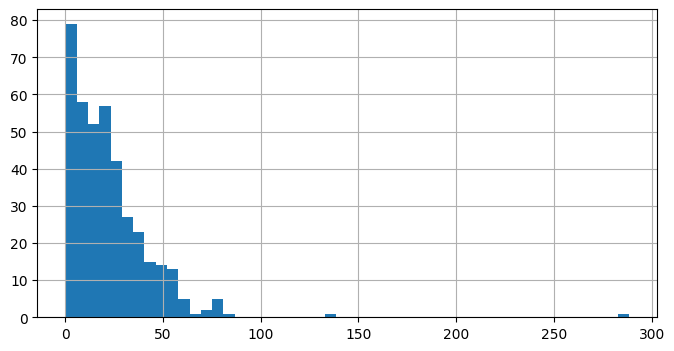

In [36]:
# Residuals plot
np.abs(y_valid - pred_valid).hist(bins = 50, figsize=(8,4))
plt.show()

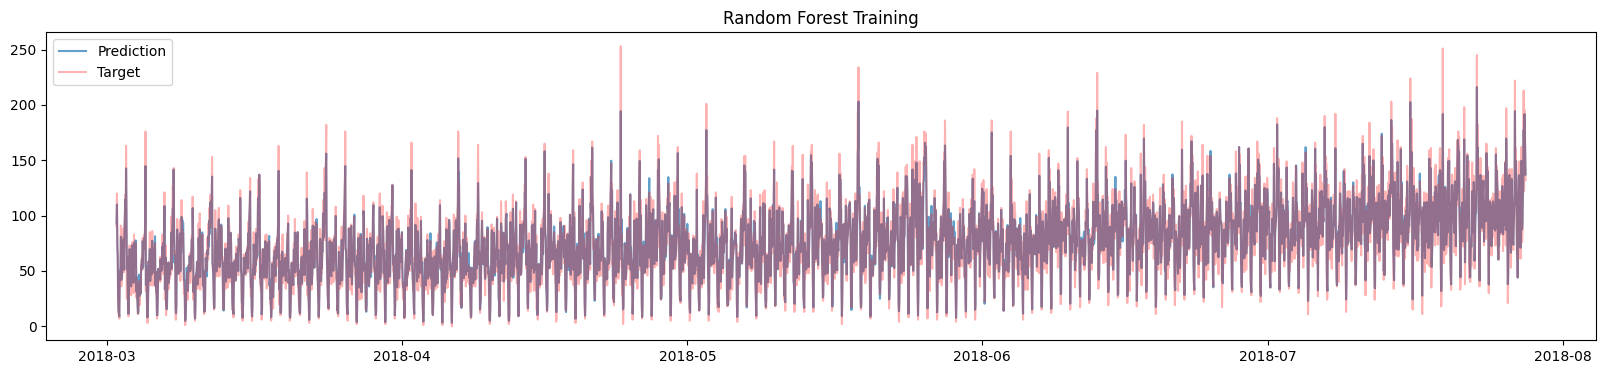

In [37]:
plt.figure(figsize=(20, 4))
plt.plot(X_train.index, pred_train, alpha=0.7, label='Prediction')
plt.plot(X_train.index, y_train, color='red', alpha=0.3, label='Target')
plt.legend(loc="upper left")
plt.title('Random Forest Training')
plt.show()

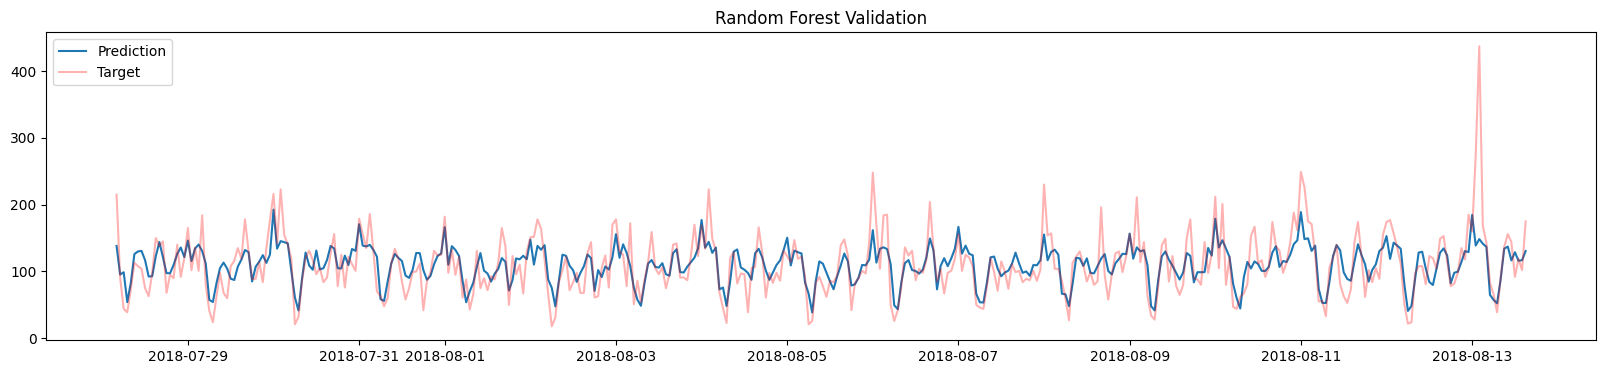

In [38]:
plt.figure(figsize=(20, 4))
plt.plot(X_valid.index, pred_valid, label='Prediction')
plt.plot(X_valid.index, y_valid, color='red', alpha=0.3, label='Target')
plt.legend(loc="upper left")
plt.title('Random Forest Validation')
plt.show()

**Concusions:**
- The trained Random Forest model misses the large spike in the validation set which is an outlier.
- It is able to predict general trends on an hourly basis fairly well.

## Testing

In [39]:
%%time
# Final Random Forest model

model_rf.fit(X_train_valid, y_train_valid)

pred_train_valid = model_rf.predict(X_train_valid)
pred_test = model_rf.predict(X_test)

# Evaluation
rmse_valid = rmse(pred_train_valid, y_train_valid)
rmse_test = rmse(pred_test, y_test)

print('Final model:')
print(f'RMSE (valid): {rmse_valid:0.2f}')
print(f'RMSE (test): {rmse_test:0.2f}')

Final model:
RMSE (valid): 8.39
RMSE (test): 41.04
CPU times: user 8.85 s, sys: 54.3 ms, total: 8.9 s
Wall time: 8.9 s


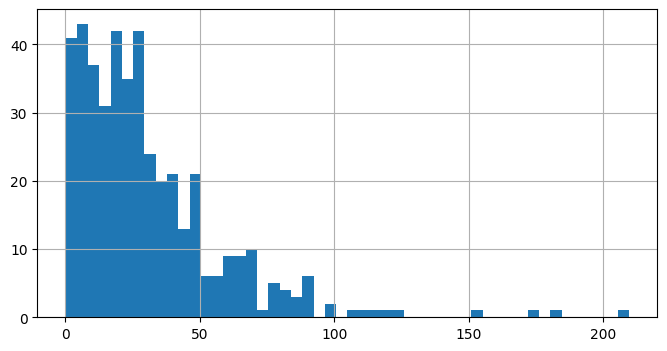

In [40]:
# Residuals plot
np.abs(y_test - pred_test).hist(bins = 50, figsize=(8,4))
plt.show()

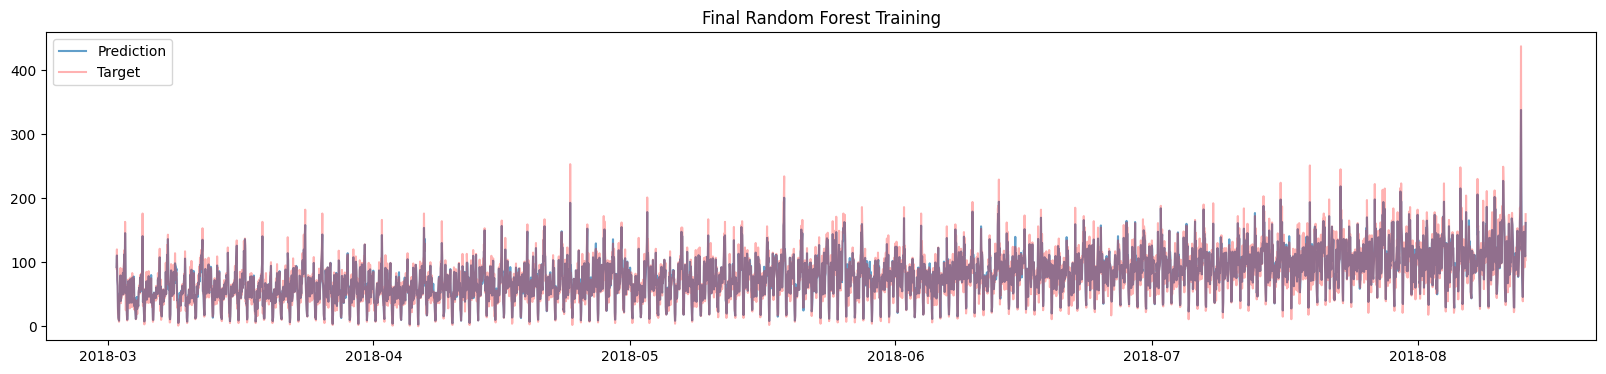

In [41]:
plt.figure(figsize=(20, 4))
plt.plot(X_train_valid.index, pred_train_valid, alpha=0.7, label='Prediction')
plt.plot(X_train_valid.index, y_train_valid, color='red', alpha=0.3, label='Target')
plt.legend(loc="upper left")
plt.title('Final Random Forest Training')
plt.show()

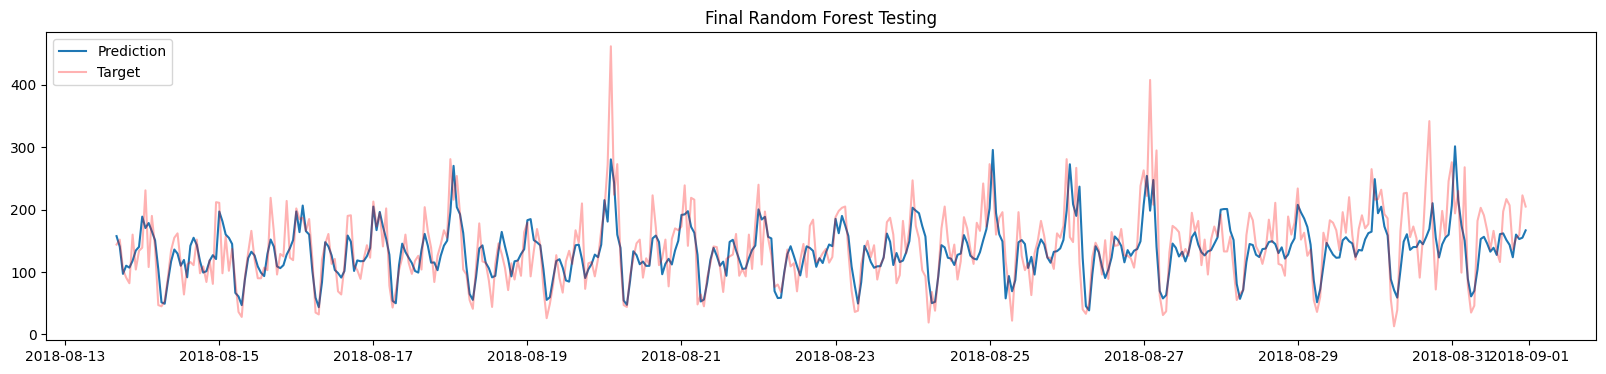

In [42]:
plt.figure(figsize=(20, 4))
plt.plot(X_test.index, pred_test, label='Prediction')
plt.plot(X_test.index, y_test, color='red', alpha=0.3, label='Target')
plt.legend(loc="upper left")
plt.title('Final Random Forest Testing')
plt.show()

### Conclusions:
- RMSE on the final test set is 41.04.
- It does a good job at predicting hourly order trends.
- The final test RMSE of the Random Forest model does not perform quite as well as during training. This is probably because it misses some of the spikes in orders that can be seen as outliers in the residuals plot. It did predict the large spike in orders that the initial validation missed.